Anota e Extrai PSFs
=============
Anota coordenadas (_picks_) de cada PSF em um painel de difrações migrado.
Dado um arquivo de _picks_, extrai as janelas com cada PSF.

---

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

# Importa bibliotecas próprias
from utils import * 

# Configura o matplolib para plotar inline
# %matplotlib qt5
#%matplotlib notebook

In [2]:
# Carrega dados sísmico de difrações migradas
stack_file = './difracoes_migradas/jequitinhonha_migrado.su'

traces = load_traces(stack_file)
stack_image = get_data_from_traces(traces)
print("Dimensões do dado 1:", stack_image.shape)
print()

Carregando o empilhamento ./difracoes_migradas/jequitinhonha_migrado.su
2079 traços:
 - CDP: [2 - 2080]
 - Amostras por traço (ns): 876
 - Tempo entre amostras (dt): 4.0 ms
Dimensões do dado 1: (876, 2079)



Anota dado. Usar botão **direito** para marcar os centros dos difratores (PSFs)

Tamanho da imagem (em polegadas): 28.88 x 12.17
Coordenadas:  x - [2.0, 2081.0], y - [0.0, 3.5]
Dimensão: (876, 2079)



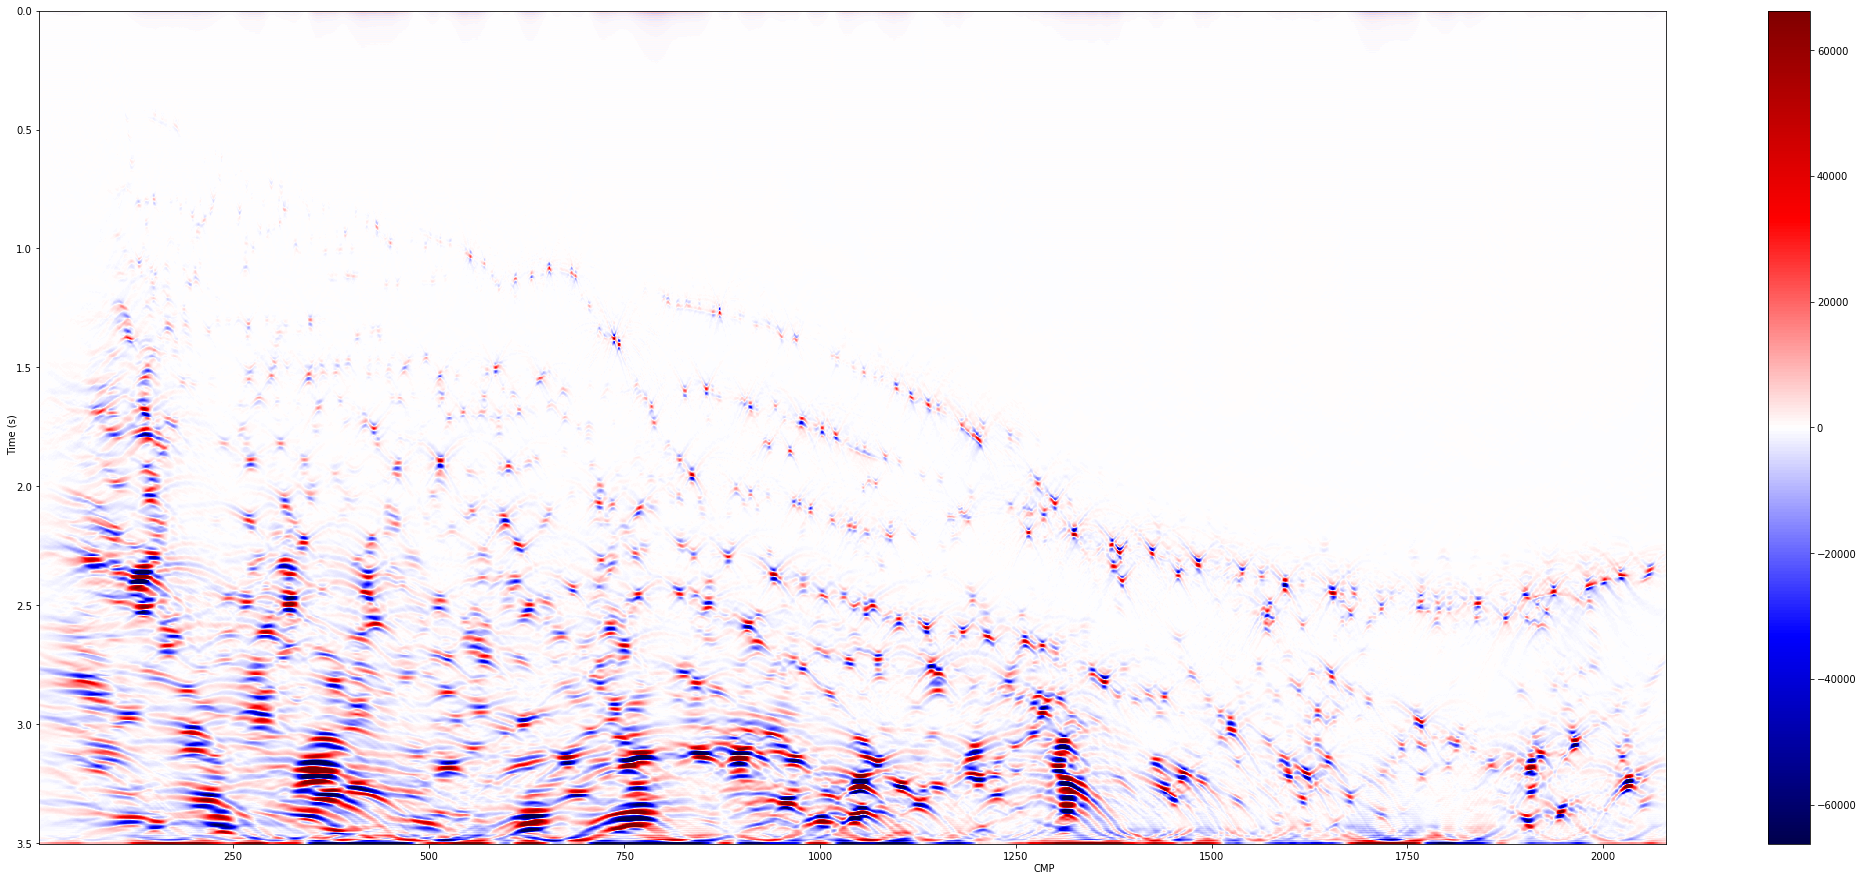

In [3]:
# Definição do arquivo de saída, que receberá as coordenadas
save_picks = './jequitinhonha_psf.txt'
save_picks = None

color = 'seismic'
plot_bar = True
clip = 0.3

multiple_event_viewer(stack_image,
             #x_begin=302, x_end=303, y_begin=0, y_end=stack_image.shape[0],
             cdp_offset=traces[0].cdp, dt=traces[0].dt,
             clip_percent1=clip, color1=color, save_file=save_picks)

Lê um arquivo de _picks_, extrai somente eventos 0.0, transforma de (cdp, tempo) para índices da matriz e remove coordenadas duplicadas.

In [4]:
def read_picks(picks_file, event_type=None):
    """
    Lê um arquivo de picks onde cada pick está no formato:
        evento=<0.0/1.0>, cdp=<num_cdp>, tempo=<tempo>
    e retorna uma lista de tuplas (cdp, tempo) ou (event_type, cdp, tempo).
    
    Args:
        picks_file: string com o nome do arquivo de picks.
        event_type: None, 0 ou 1.
            se event_type == 0: retorna lista de picks (cdp, tempo) cujos eventos eram '0.0'
            se event_type == 1: retorna lista de picks (cdp, tempo) cujos eventos eram '1.0'
            se event_type == None: retorna lista de picks (event_type, cdp, tempo)
            
    Retorno:
        picks: lista de picks cujo cada elemento é uma tupla (cdp, tempo) ou (event_type, cdp, tempo)
    """
    # Confere se evento é válido
    if not (event_type is None or event_type == 0 or event_type == 1):
        print("Erro: argumento 'event_type' deve ser None, 0 ou 1.")
        return []
    # Carrega arquivo e extrai picks
    picks = []
    with open(picks_file, 'r') as f:
        for line in f:
            # Extrai informações da string: evento, tempo e cdp
            event_ind = line.find('evento=') + 7
            event = float(line[event_ind:event_ind+3])
            time_ind = line.find('tempo=') + 6
            time = float(line[time_ind:])
            cdp_ind = line.find('cdp=') + 4
            cdp = np.floor(float(line[cdp_ind:time_ind-8]))
            # Constrói a tupla de acordo com argumento 'event_type'
            if event_type is None:
                pick = (event, cdp, time)
            elif event_type == event:
                pick = (cdp, time)
            else:
                pick = None
            # Insere pick na lista
            if not pick is None:
                picks.append(pick)
            
    return picks

In [5]:
read_picks(picks_file, event_type=2)

NameError: name 'picks_file' is not defined

In [ ]:
picks_file = './picks/jequitinhonha_psf.txt'
event_type = 0

# Carrega picks
picks = read_picks(picks_file, event_type=0)

# Transforma picks de (cdp, tempo) para índices e remove duplicatas
pick_indices = picks_to_index(picks, traces)
pick_indices = list(set(pick_indices))
print(len(pick_indices), "picks")

Gera janelas centradas nas coordenadas de cada PSF. É aplicado _tapering_ em cada janela.

In [ ]:
# Define tamanho da janela ao redor do espalhador
taper_size = 10
window_size = 21 + 2*taper_size
plot_spectrum = False

scatters = generate_samples(stack_image, window_size, pick_indices, flip=False)[0]
print("Lista de janelas:", scatters.shape)

#Normaliza, afina bordas e computa a frequência dominante de cada PSF
scatters = apply_taper(scatters, taper_size)
center = window_size/2 
dt = traces[0].dt 
frequencies = []
for i in range(scatters.shape[0]):
    # Normaliza a janela no intervalo [-1,1]
    vmax = np.max(np.abs((scatters[i].max(), scatters[i].min())))
    scatters[i] = scatters[i] / vmax
    # Computa frequencia
    center_trace = scatters[i,:,center]
    frequencies.append(get_peak_frequency(center_trace, dt, plot_spectrum=plot_spectrum))

In [ ]:
# Visualiza PSF escolhidos
max_samples = 30
resize=3.5

if max_samples < scatters.shape[0]:
    num_samples = max_samples
else:
    num_samples = None
    
view_samples(scatters, frequencies, num_samples=num_samples, resize=resize)

Estima largura de cada PSF

In [ ]:
# Realiza diferencial
center = window_size/2
num_neighbors = 2

psfs = scatters.copy()
psfs[psfs<0] *= -1
psfs = psfs[:,center-num_neighbors:center+num_neighbors+1,:]
shape = list(psfs.shape)
#shape[1] = 2*num_neighbors + 1
diffs = np.zeros(shape)
diffs[:,:,1:] = np.diff(psfs, axis=2)
diffs[:,:,center+1:] *= -1
diffs[:,:,center-2:center+3] = 1.0
diffs[diffs <= 0] = 0.0
diffs[diffs > 0] = -1.0
diffs += 1.0
mask = np.empty(shape)
mask[:,:] = np.arange(window_size)
mask *= diffs
left_bounds = center - np.median(np.max(mask[:,:,0:center], axis=2), axis=1)
mask[mask==0] = window_size
right_bounds = np.median(np.min(mask[:,:,center+1:], axis=2), axis=1)
right_bounds = np.median(np.min(mask[:,:,center+1:], axis=2), axis=1) - center
scatter_widths = np.floor((left_bounds+right_bounds)/2.0).astype(np.int)

print(scatter_widths)

In [ ]:
# Visualiza PSF escolhidos
max_samples = 30
resize=3.5

if max_samples < scatters.shape[0]:
    num_samples = max_samples
else:
    num_samples = None
    
view_samples(scatters, scatter_widths, num_samples=num_samples, resize=resize)

Salva conjunto de janelas e suas respectivas frequências

In [ ]:
# Arquivo para salvar os dados
pickle_file = 'janelas/jequitinhonha.pickle'
data = [scatters, frequencies, scatter_widths, traces[0].dt]
names = ['scatters', 'frequencies', 'scatter_widths', 'dt']

pickle_data(pickle_file, data, names)